## Import Necessary Libraries

In [ ]:
import os
import pandas as pd
from scipy.io import loadmat
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


# Download the list of folders from Google Drive
main_dir = "/content/drive/MyDrive/CRWU"


Mounted at /content/drive/


## Load and combine the data

in dataset folder we have many folders, each folder conatins .mat files of diffrent HP (motor load), we need to combine all the data in each folder to one csv file.

In [ ]:
dataset_dir = os.path.join(main_dir)

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)

    if os.path.isdir(folder_path):

        #combine all the .mat files in the folder to a single csv file
        all_data = []

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith('.mat'):

                data = loadmat(file_path)

                file_name = file.split('.')[0]
                key = 'X' + file_name.zfill(3) + '_DE_time'
                data = data[key]

                df = pd.DataFrame(data)

                all_data.append(df)

                df.to_csv(os.path.join(folder_path, file_name + '.csv'), index=False)


        all_data = pd.concat(all_data)
        all_data.to_csv(os.path.join(folder_path, folder + '.csv'), index=False)

        print(f'Processed {folder} folder')

print('Done')
data


Processed 12k_DE_BallFault_0.021 folder
Processed 12k_DE_ORFault_0.007 folder
Processed 12k_DE_IRFault_0.014 folder
Processed 12k_DE_ORFault_0.021 folder
Processed 12k_DE_ORFault_0.014 folder
Processed 12k_DE_BallFault_0.007 folder
Processed 12k_DE_IRFault_0.021 folder
Processed 12k_DE_IRFault_0.007 folder
Processed 12k_DE_BallFault_0.014 folder
Processed 12K_DE_Normal folder
Done


array([[ 0.06425354],
       [ 0.06300185],
       [-0.00438092],
       ...,
       [ 0.00521538],
       [-0.06571385],
       [-0.12266585]])

Function 1: Sampling

This function cuts a big dataset into smaller pieces (blocks).

Inputs:

Data: The big dataset.

interval_length: How far apart to start each piece.

samples_per_block: How many samples each piece should have.

Steps:

Figure out how many pieces (blocks) we can make.

Create an empty container to hold these pieces.

Loop through the dataset and cut out pieces of the specified size.

Output:

A collection of smaller pieces from the big dataset.

Function 2: DataPreparation

This function uses the Sampling function to prepare multiple big datasets for machine learning.


Inputs:

Data: A list of several big datasets.

interval_length: Same as above, how far apart to start each piece.

samples_per_block: Same as above, how many samples each piece should have.

Steps:

For each dataset in the list:

Use Sampling to cut it into pieces.

Create labels for these pieces to know where they came from.

If it’s the first dataset, start with an empty collection for pieces and labels.
For the rest of the datasets, keep adding the new pieces and labels to the existing collection.

Output:

X: All the pieces from all the datasets combined.

LabelPositional: Labels showing which dataset each piece came from, in a special format for machine learning.

Label: Simple labels showing which dataset each piece came from.

In short:

Sampling cuts datasets into smaller pieces.

DataPreparation uses Sampling to cut several datasets, labels them, and combines everything for machine learning.

In [ ]:
def Sampling(Data, interval_length, samples_per_block):
  # Calculate the number of blocks that can be sampled based on the interval length
  No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length)-1)
  SplitData = np.zeros([No_of_blocks, samples_per_block])
  for i in range(No_of_blocks):
    SplitData[i,:] = (Data[i*interval_length:(i*interval_length)+samples_per_block]).T
  return SplitData

def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(SplitData),10])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1])
    y1[:,0] = count
    # Stack up and label the data
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  return X, LabelPositional, Label



ball_007 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_BallFault_0.007/12k_DE_BallFault_0.007.csv')
ball_014 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_BallFault_0.014/12k_DE_BallFault_0.014.csv')
ball_021 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_BallFault_0.021/12k_DE_BallFault_0.021.csv')
ir_007 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_IRFault_0.007/12k_DE_IRFault_0.007.csv')
ir_014 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_IRFault_0.014/12k_DE_IRFault_0.014.csv')
ir_021 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_IRFault_0.021/12k_DE_IRFault_0.021.csv')
normal = pd.read_csv('/content/drive/MyDrive/CRWU/12K_DE_Normal/12K_DE_Normal.csv')
or_007 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_ORFault_0.007/12k_DE_ORFault_0.007.csv')
or_014 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_ORFault_0.014/12k_DE_ORFault_0.014.csv')
or_021 = pd.read_csv('/content/drive/MyDrive/CRWU/12k_DE_ORFault_0.021/12k_DE_ORFault_0.021.csv')

data_to_process = [normal, ir_007, ball_007, or_007, ir_014, ball_014, or_014, ir_021, ball_021, or_021]

interval_length = 200
samples_per_block = 1681

X, Y_CNN, Y = DataPreparation(data_to_process, interval_length, samples_per_block)

print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)


Shape of Input Data = (40106, 1681)
Shape of Label Y_CNN = (40106, 10)
Shape of Label Y = (40106, 1)


In [ ]:
XX = {'X':X}
scipy.io.savemat('Data.mat', XX)

# k-fold cross validation


In [ ]:
# k-fold cross validation
kSplits = 3
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

## 1D CNN model


In [ ]:
# Reshape the data - 1 dimensional feed
Input_1D = X.reshape([-1,1681,1])

# Test-Train Split
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

class CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model
for train, test in kfold.split(X_1D_train,y_1D_train):
    Classification_1D = CNN_1D()
    history = Classification_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12)

    # Evaluate the accuracy of the model on the training set
    kf_loss, kf_accuracy = Classification_1D.model.evaluate(X_1D_train[test], y_1D_train[test])
    accuracy_1D.append(kf_accuracy)

CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy =', CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, CNN_1D_test_accuracy = Classification_1D.model.evaluate(X_1D_test, y_1D_test)
CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy =', CNN_1D_test_accuracy)

Epoch 1/12
627/627 [==============================] - 10s 7ms/step - loss: 0.4380 - accuracy: 0.8381
Epoch 2/12
627/627 [==============================] - 3s 5ms/step - loss: 0.0637 - accuracy: 0.9762
Epoch 3/12
627/627 [==============================] - 3s 5ms/step - loss: 0.0576 - accuracy: 0.9794
Epoch 4/12
627/627 [==============================] - 4s 6ms/step - loss: 0.0320 - accuracy: 0.9886
Epoch 5/12
627/627 [==============================] - 4s 6ms/step - loss: 0.0286 - accuracy: 0.9900
Epoch 6/12
627/627 [==============================] - 3s 5ms/step - loss: 0.0293 - accuracy: 0.9902
Epoch 7/12
627/627 [==============================] - 3s 5ms/step - loss: 0.0162 - accuracy: 0.9941
Epoch 8/12
627/627 [==============================] - 4s 6ms/step - loss: 0.0228 - accuracy: 0.9919
Epoch 9/12
627/627 [==============================] - 4s 6ms/step - loss: 0.0112 - accuracy: 0.9958
Epoch 10/12
627/627 [==============================] - 3s 5ms/step - loss: 0.0283 - accuracy: 0.991

## Confusion Matrix

940/940 [==============================] - 2s 2ms/step


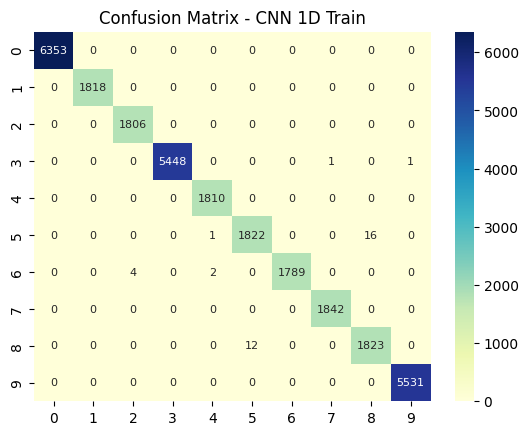

314/314 [==============================] - 1s 2ms/step


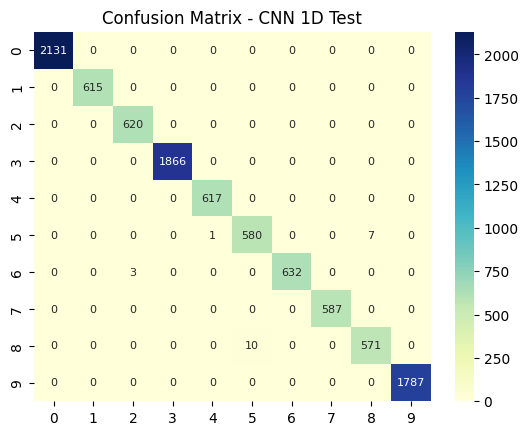

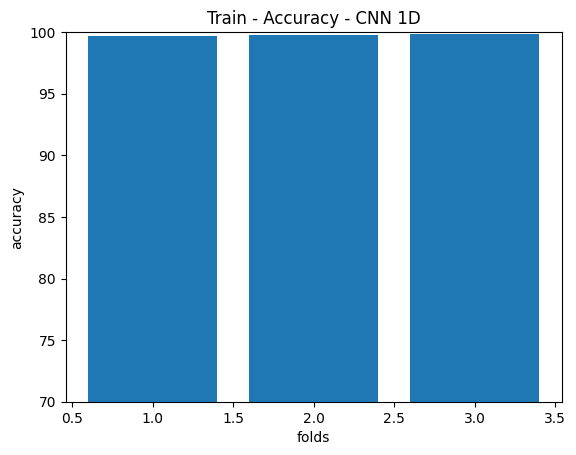

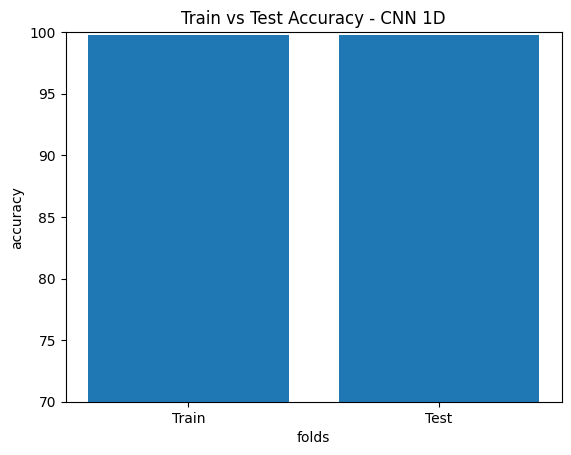

In [ ]:
def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

  plt.figure(1)
plt.title('Confusion Matrix - CNN 1D Train')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_train, y_1D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(2)
plt.title('Confusion Matrix - CNN 1D Test')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_test, y_1D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(3)
plt.title('Train - Accuracy - CNN 1D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_1D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(4)
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar([1,2],[CNN_1D_train_accuracy,CNN_1D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

## Save the model

In [ ]:
# Save the model
Classification_1D.model.save('CNN_1D.keras')
print('Model saved')

Model saved


## Predict the uploaded mat file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 97.mat to 97.mat


In [ ]:
def Sampling(Data, interval_length, samples_per_block):
    No_of_blocks = (len(Data) // interval_length) - (samples_per_block // interval_length) - 1
    if No_of_blocks <= 0:
        raise ValueError(f"Invalid number of blocks calculated: {No_of_blocks}. Check interval_length and samples_per_block.")
    print(f"No_of_blocks: {No_of_blocks}")
    SplitData = np.zeros((No_of_blocks, samples_per_block))
    for i in range(No_of_blocks):
        SplitData[i, :] = Data[i * interval_length : (i * interval_length) + samples_per_block].T
    return SplitData

#load the model
model = models.load_model('CNN_1D.keras')

file = list(uploaded.keys())[0]

data = loadmat(file)

#list the keys
data.keys()

#file name is first 4 char
file_name = file.split('.')[0]
file_name = file_name[0:3]
key = 'X' + file_name.zfill(3) + '_DE_time'

data = data[key]

print(data.shape)

interval_length = 200
samples_per_block = 1681

data = Sampling(data, interval_length, samples_per_block)

df = pd.DataFrame(data)

# Reshape the data - 1 dimensional feed
Input_1D = df.values.reshape([-1,1681,1])

Prediction_arr = model.predict(Input_1D)

predicted_class = np.argmax(Prediction_arr, axis=1)

print(predicted_class)

predicted_class_mode = np.bincount(predicted_class).argmax()  # Get the most frequent predicted class

print("Predicted class:", predicted_class_mode)



(243938, 1)
No_of_blocks: 1210
38/38 [==============================] - 0s 6ms/step
[0 0 0 ... 0 0 0]
Predicted class: 0


# Flask Goes here

### download the following for flask to run it (!!!you dont need to run this section everytime, just 1 time if you havent installed yet!!!)

In [ ]:
!pip install Flask Flask-Cors

this flask code will make python file [app.py] in and start it in a subprocess, then pyngrok will publish the app to a public url, you need to put this public url in hte html codel sample.html

In [ ]:
import subprocess
import sys
from pyngrok import ngrok

with open('app.py', 'w') as f:
    f.write("""

import subprocess
import sys
from pyngrok import ngrok
from flask import Flask, request, jsonify
from flask_cors import CORS
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import models
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Define a mapping of class numbers to class names
class_names = {
    0: "Normal",
    1: "Inner Race Fault",
    2: "Ball Fault",
    3: "Outer Race Fault",
    4: "Inner Race Fault 1",
    5: "Ball Fault",
    6: "Outer Race Fault 1",
    7: "Inner Race Fault 2",
    8: "Ball Fault 2",
    9: "Outer Race Fault 2",
    # Add more class mappings as needed
}

#data_to_process = [normal, ir_007, ball_007, or_007, ir_014, ball_014, or_014, ir_021, ball_021, or_021]

app = Flask(__name__)
CORS(app)

# Load your trained model
model = models.load_model('CNN_1D.keras')

def Sampling(Data, interval_length, samples_per_block):
    No_of_blocks = (len(Data) // interval_length) - (samples_per_block // interval_length) - 1
    if No_of_blocks <= 0:
        raise ValueError(f"Invalid number of blocks calculated: {No_of_blocks}. Check interval_length and samples_per_block.")
    SplitData = np.zeros((No_of_blocks, samples_per_block))
    for i in range(No_of_blocks):
        SplitData[i, :] = Data[i * interval_length : (i * interval_length) + samples_per_block].T
    return SplitData

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    if file:
        filepath = os.path.join("/content/", file.filename)
        file.save(filepath)

        data = loadmat(filepath)
        file_name = file.filename.split('.')[0][:3]
        key = 'X' + file_name.zfill(3) + '_DE_time'

        if key not in data:
            return jsonify({'error': f'Key {key} not found in the .mat file'}), 400

        data = data[key]
        interval_length = 200
        samples_per_block = 1681
        data = Sampling(data, interval_length, samples_per_block)

        df = pd.DataFrame(data)
        Input_1D = df.values.reshape([-1, 1681, 1])
        Prediction_arr = model.predict(Input_1D)
        predicted_class = np.argmax(Prediction_arr, axis=1)
        predicted_class_mode = np.bincount(predicted_class).argmax()

        # Get the class name from the prediction
        class_name = class_names.get(predicted_class_mode, "Unknown class")


        response = {'predicted_class': class_name}
        app.logger.debug(f'Response: {response}')

        return jsonify({'predicted_class': class_name}), 200


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
    """)

# Start the Flask app in the background
process = subprocess.Popen([sys.executable, 'app.py'])



the following code has the structure: !ngrok authtoken (key), if the key is not valid anymore, go to https://ngrok.com/ and sign up, then go to https://dashboard.ngrok.com/get-started/your-authtoken and copy the authentication code at the top of the page and paste it instead of the key in the below cell.

In [ ]:
!wget -q -O ngrok.zip https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok.zip


Archive:  ngrok.zip
  inflating: ngrok                   


In [ ]:
!pip install pyngrok


In [ ]:
!ngrok config add-authtoken 2ixNxgODSVuwgwo0Wyv1PBCo5pl_83v4QeYoRoqpfSJVLteF

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill ngrok

In [ ]:
!ngrok tunnels close tn_2iyO38EfGGsgtcQ4X3qhiLChaVK
!ngrok tunnels close tn_2iyNdQn9WQs61iJLpf5mql0kk7r
!ngrok tunnels close tn_2iyO9SHmdIPZOOnGvNGL9pA2Pl3

ngrok - tunnel local ports to public URLs and inspect traffic

USAGE:
  ngrok [command] [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backend

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP policy restrictions

In [ ]:
from pyngrok import ngrok

# Open a tunnel to the Flask server
public_url = ngrok.connect(5000, bind_tls=True)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://f8e0-35-240-133-75.ngrok-free.app" -> "http://localhost:5000"


after running the last cell, you get a publi URL, for example: <br>
https://b863-34-68-123-42.ngrok-free.app/
<br>
copy this link and go the sample.html and paste it instead of the existing link, this link will be different each time you run the code in the last cell (because google colab uses a virtual enviroment and your ip address will be different from time to time), if you want to make it perminant you need to run your code on your own computer, which will act as the server, but once you rerun the program the link will be different again.
<br>
example replacement:<br>
at line 73 in the sample.html:<br>
 url: "https://b863-34-68-123-42.ngrok-free.app/upload"
<br>
replace https://b863-34-68-123-42.ngrok-free.app, with the last link you get<br>
# !!! KEEP /upload !!!